# BREPpy sandbox


**So far:**
- Generate the cell-representing dots
- Implement knn-search
    - (Optimize speed -> Parallelize!)
- Write tests (General correct function, Comparison with scheme-BREP)

**Open questions:**
- How was the spacing 



## Parsing the Parameter file



Not nice: there are about 4 different names for one variable- there are the default ones in the code, the assigned ones in the code, and the ones in the parameter file. 
I will use variables that are similar to the ones defined in the grammar in the code, with the difference that they will be adapted to Python syntax ( _ instead of -), and a few have an additional postfix to clarify what they do (e.g. \_fn = filename) 

### On the installation of neuron
Neuron did not really work out of the box for me. 
I (ubuntu 16.04 LTS, 64 bit) did it the following way:
- Download the .rpm package from here: https://www.neuron.yale.edu/neuron/download
- Install it with: 
    `alien -i nrn_...*package*` (Note that the .deb package did not work out, and neither did the installation using rpm directly)
- Edit the .bashrc file by adding the following lines: 

    `#Added for neuron
    export PYTHONPATH="${PYTHONPATH}:/usr/local/nrn/lib/python/" `
    
    (first check that this path is actually where it got installed by going to the folder and see whether `python -c 'import neuron'` tells you about your NEURON version or whether there ain't no module called neuron.


http://www.davison.webfactional.com/notes/hoc-to-python-bulbnet/

In [1]:
import argparse
import numpy as np
import datetime
import pickle 
import warnings
import neuron
import sys
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#! echo $PYTHONPATH

In [ ]:
%run BREPpy.py

#Todo: Read in from command line for int or bool parameters.
b = Brep()
b.init_from_script(['--config_fn','./input_files/Parameters.hoc'])
b.read_in_config()

## Checking out the output of the original BREP program.

### File read-in procedures

In [2]:
##filenames and input paths for the different files.
import os
from collections import OrderedDict

path_4 = os.getcwd()+'/output_25/'
path_16 = os.getcwd()+'/output_16/'
path_full = os.getcwd()+'/output_full_def/'
path_old = os.getcwd()+'/output_1/'
path_ivan = os.getcwd()+'/brep-ivan/'
path_dropin = os.getcwd()+'/dropbox_input/'

path = path_full

fns = OrderedDict ()
fns['aa_go_dist']='AAtoGoCdistances.dat'
fns['aa_go_segs']='AAtoGoCsegments.dat'
fns['aa_go_source']='AAtoGoCsources.dat'
fns['aa_go_target']='AAtoGoCtargets.dat'

fns['gran_coord'] ='GCcoordinates.sorted.dat'       
fns['gran_t_coord']='GCTcoordinates.sorted.dat'
    
fns['go_coord']='GoCcoordinates.sorted.dat'
fns['go_basd_coord']='GoCbdendcoordinates.sorted.dat'
fns['go_apical_coord']='GoCadendcoordinates.sorted.dat'
fns['go_axon_coord']='GoCaxoncoordinates.sorted.dat'
fns['go_dist']='GoCdistances.dat' 
       
fns['go_go_dist']='GoCtoGoCdistances.dat'
fns['go_go_source']='GoCtoGoCsources.dat'
fns['go_go_target']='GoCtoGoCtargets.dat'
fns['go_go_gap_dist']='GoCtoGoCgapdistances.dat'
fns['go_go_gap_source']='GoCtoGoCgapsources.dat'
fns['go_go_gap_target']='GoCtoGoCgaptargets.dat'

fns['pf_go_dist']='PFtoGoCdistances.dat'
fns['pf_go_seg']='PFtoGoCsegments.dat'
fns['pf_go_source']='PFtoGoCsources.dat'
fns['pf_go_target']='PFtoGoCtargets.dat'

#for k,v in fns.items():
##    print (k)
#a = import_csv(in_f)
#rr = read_in_coordfile (in_goba)

In [3]:

#def import_csv (fn):
def read_in_coordfile (fn, parse_ignore = True):
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        err = []
        for line in rr:
            ar = []
            for j in range(len(line)):
                try: ar.append(float(line[j]))
                except: err.append(line[j])
            res.append(np.asarray(ar))
    if len(err)> 0 and not parse_ignore: print ('Could not parse on {} instances: {}'.format(len(err), set(err)))
    return np.asarray(res)

#reshape
def coord_reshape (dat):
    dat = dat.reshape([dat.shape[0], int(dat.shape[1]/3),3])
    return dat

#rr = read_in_coordfile(fn)

### Overview over the different output files

In [ ]:
# An overview over the different files that BREP produces and the comparison between two different files
for k, v in fns.items():
    print ('Read in file: ', v)
    c_p = path+v
    cur = read_in_coordfile(c_p)
    
    #c_p2 = os.getcwd()+'/output_2/'+v
    #cur2 = read_in_coordfile(c_p2)

    print ('Shape 1 is: ', cur.shape)
    #print ('Shape 2 is: ', cur2.shape)
    
    print ('First elements in 1 are:', cur.flatten()[:15])
    #print ('First elements in 2 are:', cur2.flatten()[:15])
    
    print (' ')

### Connectivities

In [4]:

def target_stats (dat, name = ''):
    un, counts = np.unique(dat, return_counts=True)
    print (name)
    print ('Connections per cell: ', round(np.mean(counts),2),'+/-', round(np.std(counts), 2), ', range ', min(counts),'-', max(counts))


In [ ]:
path = path_full
gap_t = read_in_coordfile(path + fns['go_go_gap_target'])
pf_t = read_in_coordfile(path + fns['pf_go_target'])
aa_t = read_in_coordfile(path+fns['aa_go_target'])
gg_t = read_in_coordfile(path+fns['go_go_target'])

target_stats(gg_t, 'Golgi to Golgi:')
target_stats(aa_t, 'AA to Golgi:')
target_stats(pf_t, 'Parallel Fiber to Golgi:')
target_stats(gap_t, 'Golgi to Golgi gap junctions:')

print(
'''
Here are the paper values as a comparison:
Golgi to Golgi:
Connections per cell:  144.85 +/- 36.88 , range  72 - 195
AA to Golgi:
Connections per cell:  554 +/- 302 , range  55 - 1245
Parallel Fiber to Golgi:
Connections per cell:  4759 +/- 1037, range 2512-6582
Golgi to Golgi gap junctions:
Connections per cell:  13.7 +/- 4.6 , range  1-31''')

### Golgi-Granule interactions

In [24]:
Go_ori = read_in_coordfile(path+fns['go_coord']) #soma points of granule cells
Gr_ori = read_in_coordfile(path+fns['gran_coord']) #soma points of Golgi cells
GrT_ori = read_in_coordfile(path+fns['gran_t_coord'])
pf_t = read_in_coordfile(path+fns['pf_go_target']) #the Golgi cell ID
pf_s = read_in_coordfile(path+fns['pf_go_source']) #number = the parallel fiber ID
aa_t = read_in_coordfile(path+fns['aa_go_target'])
aa_s = read_in_coordfile(path+fns['aa_go_source'])



In [25]:
#n_Go = 200
#n_Gr = 10000

#print (int(max(pf_s)))
#print (max(pf_t))

def so_tar_sets (so, tar, n_so = -1, n_tar = -1):
    '''Takes two lists of sources and targets (must have same length), and constructs a list of set from it.
    Output = source-> target, target -> source'''
    if n_so<0: n_so = int(max(so)+1)
    if n_tar<0: n_tar = int(max(tar)+1)
    so_tar = [set() for i in range(n_so)]
    tar_so = [set() for i in range(n_tar)]
    for s, t in zip (so, tar):
        so_tar[int(s)].add(int(t))
        tar_so[int(t)].add(int(s))
    return so_tar, tar_so

#go_gr = [set() for i in range(n_Go)]
#gr_go = [set() for i in range(n_Gr)]

#for s,t in zip(pf_s, pf_t):
#    go_gr[int(t)].add(int(s))
#    gr_go[int(s)].add(int(t))
    
gr_go, go_gr = so_tar_sets(pf_s, pf_t)

print (gr_go[:10])
print (go_gr[:10])

ls= [len(gr_go[i]) for i in range(len(gr_go))]
print (np.argmax(ls))

ks= [len(go_gr[i]) for i in range(len(go_gr))]
print (np.argmax(ks))

#print (gogr1)

[set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
75429
447


### Visualization

1995
798000


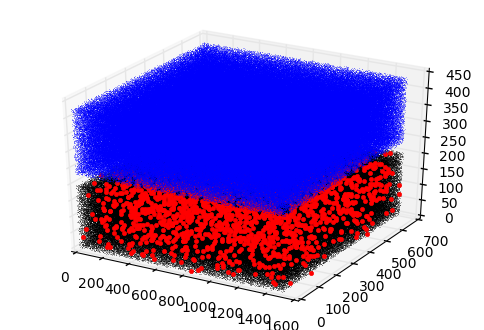

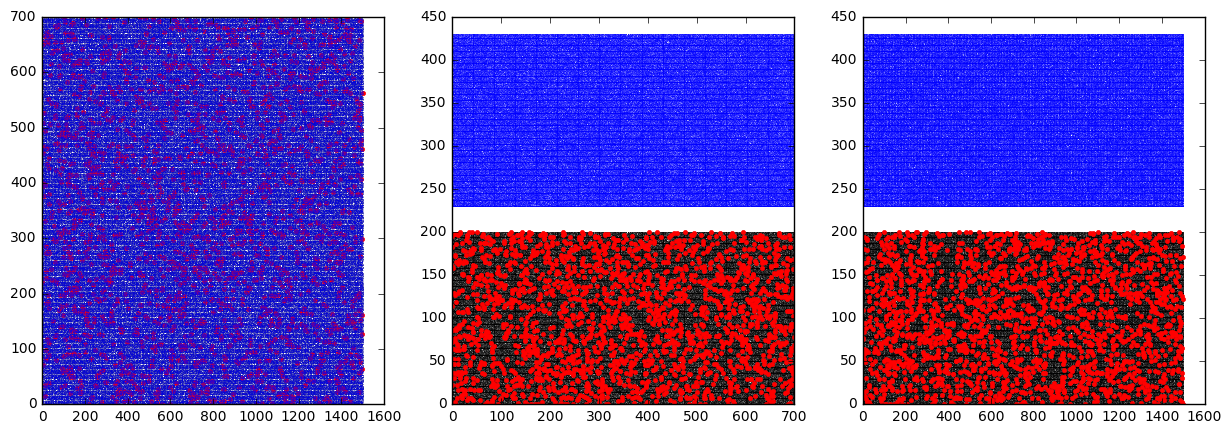

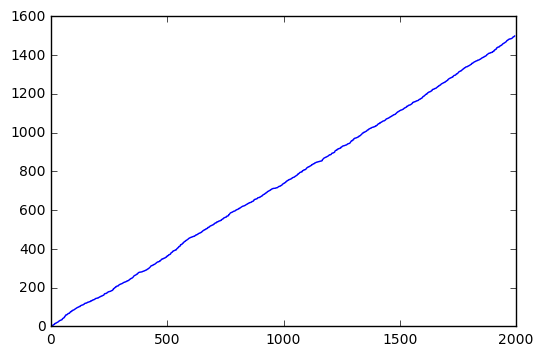

In [51]:
#path_v = path_ivan
#path_v = path_4
#path_v = path_full
path_v = path_dropin

gr_iv = read_in_coordfile(path_v + 'GCcoordinates.dat')
grt_iv = read_in_coordfile(path_v + 'GCTcoordinates.dat')
go_iv = read_in_coordfile(path_v + 'GoCcoordinates.dat')

#gr_iv = read_in_coordfile(path_v + fns['gran_coord'])
#grt_iv = read_in_coordfile(path_v + fns['gran_t_coord'])
#go_iv = read_in_coordfile(path_v + fns['go_coord'])

pop_1 =  gr_iv# small dots
pop_2 =  go_iv# big dots
pop_3 = grt_iv

fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d(ax, pop_1, 'k.', markersize=0.2)
plot3d(ax, pop_2, 'r.')
plot3d(ax, pop_3, 'b.', markersize=0.2)

plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(pop_1[:,j], pop_1[:,k],  'k.', markersize=0.1)
    plt.plot(pop_2[:,j], pop_2[:,k],  'r.')
    plt.plot(pop_3[:,j], pop_3[:,k],  'b.', markersize=0.1)

print (len(go_iv))
print (len(gr_iv))

x_go = go_iv[:,0]
plt.figure()
plt.plot(np.sort(x_go))


In [ ]:
! ls brep-ivan/

In [ ]:
#n = 9# 3d plot
ks= [len(go_gr[i]) for i in range(len(go_gr))]
ls= [len(gr_go[i]) for i in range(len(gr_go))]

pop_1 =  gr_iv# small dots
pop_2 =  go_iv# big dots
pts_1 = Go_ori[np.array(list(gr_go[np.argmax(ls)]))]

pts_2 = Gr_ori[np.array(list(go_gr[np.argmax(ks)]))]#[np.array(Gid_aa[n]),:]

fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d(ax, pop_1, 'k.', markersize=0.2)
plot3d(ax, pop_2, 'ro')
plot3d(ax, pts_1, 'go')
#ax.plot(all_pts[0,0],all_pts[0,1],all_pts[0,2], 'go')
plot3d(ax, pts_2, 'bo', markersize=1.0)
plt.axis('equal')

plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(pop_1[:,j], pop_1[:,k],  'k.', markersize=0.2)
    plt.plot(pop_2[:,j], pop_2[:,k],  'ro')
    plt.plot(pts_1[:,j], pts_1[:,k], 'go')
    plt.plot(pts_2[:,j], pts_2[:,k], 'bo', markersize=4.0)
    plt.axis('equal')
    plt.title(tit)
    
plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(pop_1[:,j], pop_1[:,k],  'k.', markersize=0.3)
    plt.plot(pop_2[:,j], pop_2[:,k],  'ro')
    plt.plot(pts_1[:,j], pts_1[:,k], 'go')
    plt.plot(pts_2[:,j], pts_2[:,k], 'bo', markersize=2.0)
    plt.title(tit)

In [34]:
#gr and grt relation: grt = gr + [0, 0, 200]
#gr_c = read_in_coordfile(path+fns['gran_coord'])
#grt_c = read_in_coordfile(path+fns['gran_t_coord'])
print (sum (gr_iv-grt_iv) / len (gr_iv))

print

[   0.    0. -230.]


<function print>

### Golgi-Golgi interactions

In [5]:
def conrad_hist (dis, tit ='connectivity radius'):
    plt.figure()
    aux = plt.hist(dis, bins = 100)
    plt.xlabel('radius')
    plt.ylabel('number of connections')
    plt.title (tit)


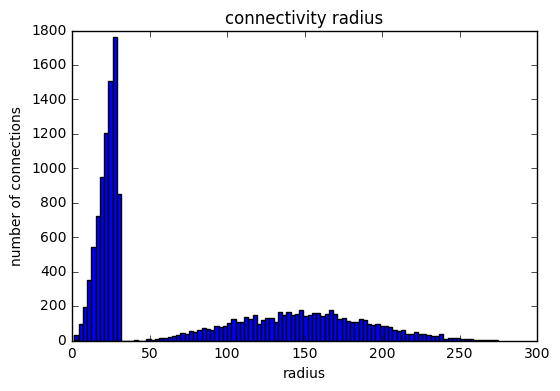

In [53]:
## golgi-golgi interactions
src = read_in_coordfile(path+fns['go_go_source'])
tar = read_in_coordfile(path+fns['go_go_target'])
dis = read_in_coordfile(path+fns['go_go_dist'])
coord = read_in_coordfile(path+fns['go_coord'])

res_n = np.zeros(100)
for i in range(100):
    #res_n[i] = np.linalg.norm(coord[int(tar[i]),:]-coord[int(src[i]),:])
    res_n[i] = (sum((coord[int(tar[i]),:]-coord[int(src[i]),:])**2)**0.5)


# Checking out the connectivities per GC
#n_Go = 200
#source files

    
conrad_hist(dis)

In [ ]:
src_g = read_in_coordfile(path+fns['go_go_gap_source'])
tar_g = read_in_coordfile(path+fns['go_go_gap_target'])
dis_g = read_in_coordfile(path+fns['go_go_gap_dist'])
conrad_hist(dis_g)

### Notable things
- BREP does not seem to take into account the densities from the config file. It just uses the number of Golgi/Granule cells that are defined in its default. The parameters NumGC or NumGoC which is defined in the input dict does not exist in the Parameter.hoc file at all.
- BREP does not seem to check for or find out if there is a number of GCT points that is not related to the number of GC points. It just simulates GC points with aa independently of the GCT points that are the origin of the PF
- The connectivity also does not correspond 

## Golgi cells


### Generation
Shitty here, look at the Check-out-Golgi notebook

In [6]:
def gen_dendrites (som, c_r, c_h, c_m, c_std, c_sp, col = 'kx', plot_fig = False):
    '''Generates dendrites as described in the paper:
    som = coordinates of somata
    c_r = maximal radius of cone
    c_h = height of cone
    c_m = mean angle for each dendrite (number of elements = number of dendrites per cell)
    c_std = standard deviation (degree) for the angle of the dendrite
    c_sp = spacing between the points
    col = color if plot function is enabled
    plot_fig = plot the results?
    Returns a list of lists containing arrays with the coordinates of the dendrites
    '''
    c_n = int(np.linalg.norm([c_r, c_h])/c_sp) #number of points per dendrite
    c_gr = np.linspace(0,1,c_n)*np.ones((3, c_n)) #linspace grid between 0 and 1 with c_n elements
    b_res = []
    for i in range(len(som)): #each cell
        som_c = som[i,:]
        d_res = []
        for cc_m in c_m: #each dendrite
            ep_ang = (np.random.randn()*c_std + cc_m)*np.pi/180 #angle
            pt = ([np.sin(ep_ang)*c_r, np.cos(ep_ang)*c_r, c_h])*c_gr.T #coordinates of the dendrite = endpoint*grid 
            if plot_fig: ax.plot(pt[:,0], pt[:,1], pt[:,2], col);
            d_res.append(pt+som_c) 
        b_res.append(d_res)
    return b_res

a_h = 332.0
a_r= 100.0
b_h = -6.0
b_r = 60.0
a_m = [30.0, 120.0]
b_m = [-20.0, -240.0]
b_std = 10
a_std = 10
a_sp = 6.6
b_sp = 14.4

#coord = read_in_coordfile(path+fns['go_coord']) #soma points

#a_dend = gen_dendrites(coord, a_r, a_h, a_m, a_std, a_sp, 'gx')
#b_dend = gen_dendrites(coord, b_r, b_h, b_m, b_std, b_sp, 'kx')

### Visualization

In [15]:
# Visualize Golgi cells
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#read in
coord = read_in_coordfile(path+fns['go_coord'])
apical = read_in_coordfile(path+fns['go_apical_coord'])
basal = read_in_coordfile(path+fns['go_basd_coord'])
axon = read_in_coordfile(path+fns['go_axon_coord'])
new_ap = read_in_coordfile('new_apical.dat', parse_ignore=False)
new_bas = read_in_coordfile('new_basal.dat', parse_ignore=False)
new_ax = read_in_coordfile('new_axon.dat', parse_ignore=False)


apical = apical.reshape([apical.shape[0],int(apical.shape[1]/3),3])
basal = basal.reshape([basal.shape[0],int(basal.shape[1]/3),3])
axon = axon.reshape([axon.shape[0],int(axon.shape[1]/3),3])
print (axon.shape)
new_ap = coord_reshape(new_ap)
new_bas = coord_reshape(new_bas)
print( new_ax.shape)
new_ax = coord_reshape(new_ax)


(1995, 20, 3)
(200, 120)


In [16]:
# dendrite spacing
ap = apical[1,:]
bas = basal[1,:]
resa = [np.linalg.norm(ap[j,:]-ap[j+1,:]) for j in range(len(ap)-1)]
resb = [np.linalg.norm(bas[j,:]-bas[j+1,:]) for j in range(len(bas)-1)]

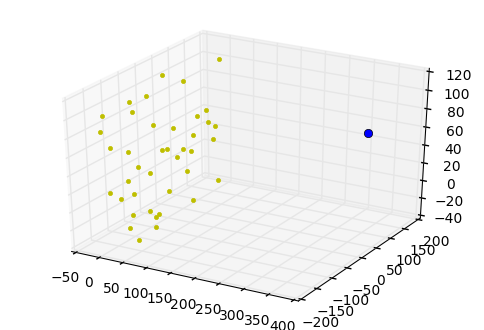

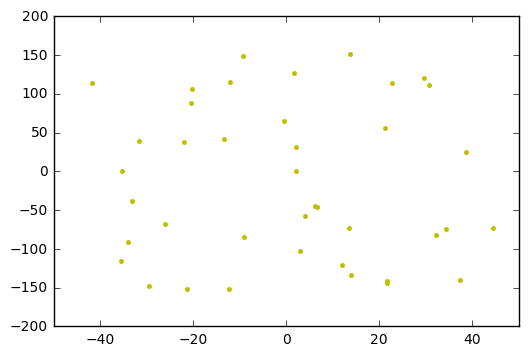

In [17]:
# plot
ns = np.arange(1) #neurons to be plotted.

plot_somata = True
plot_apical = 0
plot_basal = 0
plot_axon = 0
plot_new_ap = 0
plot_new_bas  = 0
plot_new_ax = 1
overlay = 0

options= [
    (apical, plot_apical, 'kx'),
    (basal, plot_basal, 'gx'), 
    (axon, plot_axon, 'r.'), 
    (new_ap, plot_new_ap, 'cx'),
    (new_bas, plot_new_bas, 'mx'),
    (new_ax, plot_new_ax, 'y.')]


fig = plt.figure()
ax = fig.gca(projection='3d')
if plot_somata: 
    if not overlay: ax.plot(coord[ns,0], coord[ns,1], coord[ns,2], 'bo')
    else: ax.plot ([0],[0],[0],'bo')

#plot dendrites and axon.
for pts, yn, col in options:
    for i in ns:
        if yn:
            if overlay: pt = pts[i,:,:]-coord[i,:]
            else: pt = pts[i,:,:]
            ax.plot(pt[:,0], pt[:,1], pt[:,2], col)

#ax.view_init(30,180)
proj2D = True
if proj2D:
    plt.figure()
    for pts, yn, col in options:
        for i in ns:
            if yn:
                if overlay: pt = pts[i,:,:]-coord[i,:]
                else: pt = pts[i,:,:]
                plt.plot(pt[:,0], pt[:,1], col)

### Distances

In [ ]:
goc = read_in_coordfile(path_ivan+fns['go_coord'])

res = np.zeros((40000, 3))
for i in range(200):
    for j in range(200):
        res[i*200+j,:] = goc[i,:]-coord[j,:]
#dist = [coord[i,:]-coord[j,:] for i,j in range(200)]
dist = read_in_coordfile(path+fns['go_dist'])

#print (res[1:100,:] + dist[:99,:])
#the distances file just contains all possible differences betwween the different Golgi cells, rounded in an inconsistant way.

## Granule cells

In [7]:
aa_length = 200.0
aa_step = 50.0 #this might have to be adapted if the length is not divisable by step
pf_length = 1000.0
pf_step = 7.5


def gen_aa_and_pf (coo, aa_length, aa_step, pf_length, pf_step, plot = False):
    
    if plot:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    
    aa_nd = int(aa_length/aa_step) + 1 
    aa_sp = np.linspace(0, aa_length, aa_nd)

    pf_nd = int(2*pf_length/pf_step) + 1
    pf_sp = np.linspace(-pf_length, pf_length, pf_nd)

    aa_dots = np.zeros((len(coo), aa_nd, 3))
    pf_dots = np.zeros((len(coo), pf_nd, 3))
    for i, som in enumerate(coo):
        aa_dots[i] = np.ones((aa_nd, 3))*som
        aa_dots[i,:,2] = aa_dots[i,:,2] + aa_sp
        pf_dots[i] = np.ones((pf_nd,3))*aa_dots[i,-1, :]
        pf_dots[i,:,0] = pf_dots[i,:,0] + pf_sp
        if plot:
            plot3d(ax, aa_dots[i], 'ko', markersize=1.0)
            plot3d(ax, pf_dots[i], 'r.', markersize=1.0)
    return aa_dots, pf_dots
#an idea: can we not use a wider, but more random spacing? Like that there are less points, but the connectio


def gen_aa_random (coo, mol_range  = [230, 430]):
    aa_dots = np.array([np.array([coo[i], coo[i]]) for i in range(len(coo))])
    aa_dots[:,1,2] = np.random.uniform(mol_range[0], mol_range[1], len(aa_dots[:,1,2]))
    return aa_dots

def gen_aa_fixed (coo, aa_length =200):
    aa_dots = np.array([np.array([coo[i], coo[i]]) for i in range(len(coo))])
    aa_dots[:,1,2] = aa_dots[:,1,2] + aa_length
    return aa_dots

def gen_pf_from_aa (aa_dots, pf_length):
    ''' '''
    pf_dots = aa_dots.copy()
    pf_dots[:,0,2] = pf_dots[:,1,2] #z axis shall be the same
    pf_dots[:,0,0] = pf_dots[:,0,0] - pf_length
    pf_dots[:,1,0] = pf_dots[:,1,0] + pf_length
    
    return pf_dots







In [ ]:
# 3D Test
coo = Gr_co #[:10,:]
aa_d, pf_d = gen_aa_and_pf (coo, aa_length, aa_step, pf_length, pf_step)

In [38]:
#2D Test
aa_d2 = gen_aa_random (coo, mol_range  = [230, 430])
aa_d3 = gen_aa_fixed (coo, aa_length =230)

pf_d2 = gen_pf_from_aa (aa_d2, pf_length)

#aa_d2, pf_d2 = gen_pts_for_2dt (coo, aa_length, pf_length)
print (pf_d2.shape)
print (aa_d2.shape)


plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(aa_d2 [:,0,j], aa_d2[:,0,k],  'k.', markersize=0.2)
    plt.plot(aa_d2 [:,1,j], aa_d2[:,1,k],  'g.', markersize=0.2)
    plt.plot(pf_d2 [:,1,j], pf_d2[:,1,k],  'r.', markersize=0.2)
    plt.plot(pf_d2 [:,0,j], pf_d2[:,0,k],  'm.', markersize=0.2)
    plt.axis('equal')
    plt.title(tit)

NameError: name 'coo' is not defined

## Population building

### Somata

In [8]:
# Somata generating method 

#Dimensions of the Granule cell layer
Gc_x = 750
Gc_y = 375
Gc_z = 200

n_Go = int(2000*Gc_x*Gc_y/700/1500)
n_Gr = 2000*n_Go
#print (n_Go)
#print (n_Gr)

def get_cell_loc (n_cell, Gc_x, Gc_y, Gc_z):
    # get spacing for grid:
    vol_c = Gc_x*Gc_y*Gc_z/n_cell
    sp_def = vol_c**(1/3)/2
    
    #first get a few too many
    gr = np.asarray([[i,j,k] 
                     for i in np.arange(0, Gc_x, 2*sp_def)   
                     for j in np.arange(0, Gc_y, 2*sp_def) 
                     for k in np.arange(0, Gc_z, 2*sp_def)])

    grc = gr + np.random.randn(*gr.shape)*sp_def
    #then remove the ones that lie most outside to get the correct number of cells
    
    lower = grc.T.ravel()
    upper = -(grc-[Gc_x, Gc_y, Gc_z]).T.ravel()
    most_out_idx = np.mod(np.argsort(np.concatenate((lower,upper))), len(grc))
    del_el = len(grc) - n_cell # number of elements to be deleted
    n_del = del_el
    
    while len(np.unique(most_out_idx[:n_del])) < del_el:
        n_del = n_del + del_el - len(np.unique(most_out_idx[:n_del]))
        
    grc = grc[np.setdiff1d(np.arange(len(grc)), most_out_idx[:n_del]),:]
    return grc


def plot3d (ax, dat, *args, **kwargs):
    ax.plot(dat[:,0], dat[:,1], dat[:,2], *args, **kwargs)




### All population points

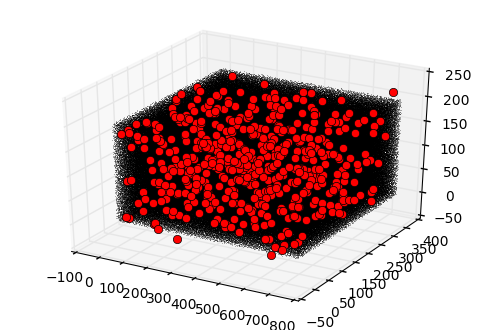

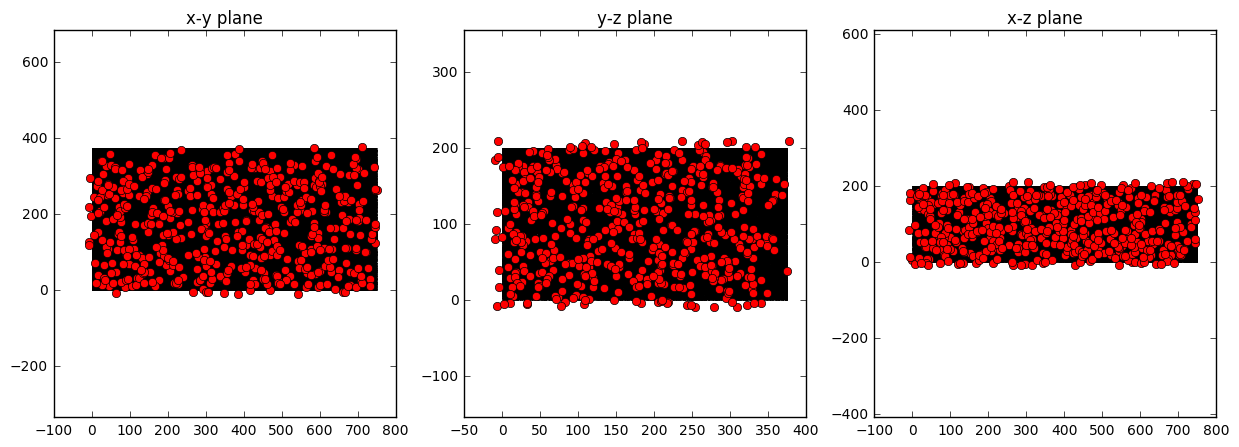

In [37]:
# get the two populations
Gr_co = get_cell_loc(n_Gr, Gc_x, Gc_y, Gc_z)
Go_co = get_cell_loc(n_Go, Gc_x, Gc_y, Gc_z)
G

# 3d plot
fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d(ax, Gr_co, 'k.', markersize=0.2)
plot3d(ax, Go_co, 'ro')

#projections
plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(Gr_co[:,j], Gr_co[:,k],  'k.', markersize=0.2)
    plt.plot(Go_co[:,j], Go_co[:,k],  'ro')
    plt.axis('equal')
    plt.title(tit)


## kNN experiments

### Assembling the points

In [9]:
from sklearn.neighbors import KDTree as kdt

#General slice information
Gc_x = 150
Gc_y = 30
Gc_z = 200
#Golgi cell dendrite parameters
a_h = 332.0
a_r= 100.0
b_h = -6.0
b_r = 60.0
a_m = [30.0, 120.0]
b_m = [-20.0, -240.0]
b_std = 10
a_std = 10
a_sp = 6.6
b_sp = 14.4
#Granule cell parameters
aa_length = 200.0
aa_step = 50.0 #this might have to be adapted if the length is not divisable by step
pf_length = 1000.0
pf_step = 7.5

#number of cells (use densities later!)
Go_dens  = 9.5e-6 # from the paper: n_cells/ym³
Gr_Go_ratio = 400


def dend_to_default_format (dend):
    '''change format of the lists from the gen_dendrites function to cells*points*coordinates'''
    dd = np.asarray([np.concatenate((dend[i][0], dend[i][1])) for i in range(len(dend))])
    return dd

# !! Relies on global variables
def full_pop (Gc_x, Gc_y, Gc_z=200, dim2 = True, random_aa = False):
    ''' will give you a full population including points for a given size, in order to make generation easier
    '''
    n_Go = int (Go_dens*Gc_x*Gc_y*Gc_z)
    n_Gr = Gr_Go_ratio*n_Go
    print ('Number of Golgi cells:',n_Go)
    print ('Number of Granule cells:', n_Gr)
    # get the two populations4
    Gr_co = get_cell_loc(n_Gr, Gc_x, Gc_y, Gc_z)
    Go_co = get_cell_loc(n_Go, Gc_x, Gc_y, Gc_z)
    # get the dendrites
    a_dend = dend_to_default_format(gen_dendrites(Go_co, a_r, a_h, a_m, a_std, a_sp, 'gx'))
    b_dend = dend_to_default_format(gen_dendrites(Go_co, b_r, b_h, b_m, b_std, b_sp, 'kx'))
    
    if dim2:
        if random_aa: aa_d = gen_aa_random (Gr_co, mol_range  = [230, 430])
        else: aa_d = gen_aa_fixed (Gr_co, aa_length =200)
        pf_d = gen_pf_from_aa (aa_d, pf_length)
    else: aa_d, pf_d = gen_aa_and_pf(Gr_co, aa_length, aa_step, pf_length, pf_step)
        
    return (Gr_co, Go_co, a_dend, b_dend,  aa_d, pf_d)
    
def flatten_cells (dat):
    return dat.reshape(dat.shape[0]*dat.shape[1],dat.shape[2])

def get_golgi_ind (a_dend, b_dend):
    a_ind = (np.ones((a_dend.shape[1], a_dend.shape[0]))*np.arange(a_dend.shape[0])).T
    b_ind = (np.ones((b_dend.shape[1], b_dend.shape[0]))*np.arange(b_dend.shape[0])).T
    gol_ind = np.concatenate((flatten_cells(np.expand_dims(a_ind, axis = 2)), flatten_cells(np.expand_dims(b_ind, axis = 2)))).astype('int')
    return gol_ind

In [ ]:
n_Go = int (Go_dens*Gc_x*Gc_y*Gc_z)
n_Gr = Gr_Go_ratio*n_Go
print (n_Go)
print (n_Gr)

# get the two populations4
Gr_co = get_cell_loc(n_Gr, Gc_x, Gc_y, Gc_z)
Go_co = get_cell_loc(n_Go, Gc_x, Gc_y, Gc_z)

# get the dendrites
a_dend = dend_to_default_format(gen_dendrites(Go_co, a_r, a_h, a_m, a_std, a_sp, 'gx'))
b_dend = dend_to_default_format(gen_dendrites(Go_co, b_r, b_h, b_m, b_std, b_sp, 'kx'))

# get aa and pf
aa_d, pf_d = gen_aa_and_pf(Gr_co, aa_length, aa_step, pf_length, pf_step)

### SKL implementation 1

In [ ]:
Gr_co, Go_co, a_dend, b_dend,  aa_d, pf_d = full_pop (15, 10, Gc_z=200)
kt_aa = kdt(flatten_cells(aa_d))
kt_pf = kdt(flatten_cells(pf_d))
# 4 Golgi cells -> around 40-50 s
# 8 Golgis -> around 130 s -> about 4.3e6 pts --> if we represent all aa with 5 pts, this is feasible (will be around 4e6 pts)

In [ ]:

# connection radius
c_rad_aa = 30.0
c_rad_pf = 5.0
#number of points per granule cell 
n_pt_aa = aa_d.shape[1]
n_pt_pf = pf_d.shape[1]

res_aa_a = []
for i, pt in enumerate(flatten_cells(a_dend)):
    warnings.simplefilter('ignore')
    ind, = kt_aa.query_radius(pt, r= c_rad_aa)
    res_aa_a.append(np.unique((np.floor(ind/n_pt_aa)).astype('int')))
    
res_aa_b = []
for i, pt in enumerate(flatten_cells(b_dend)):
    warnings.simplefilter('ignore')
    ind, = kt_aa.query_radius(pt, r= c_rad_aa)
    res_aa_b.append(np.unique((np.floor(ind/n_pt_aa)).astype('int')))
    

    
res_pf_a = []
gr_f = []
for i, pt in enumerate(flatten_cells(a_dend)):
    warnings.simplefilter('ignore')
    ind, = kt_pf.query_radius(pt, r= c_rad_pf)
    if len(ind) > 0: gr_f.append(i)
    res_pf_a.append(np.unique((np.floor(ind/n_pt_pf)).astype('int')))
    
res_pf_b = []
for i, pt in enumerate(flatten_cells(b_dend)):
    warnings.simplefilter('ignore')
    ind, = kt_pf.query_radius(pt, r= c_rad_pf)
    if len(ind) > 0: print (i)
    res_pf_b.append(np.unique((np.floor(ind/n_pt_pf)).astype('int')))
    

### 2D SKL implementation

**Idea behind this:**
It seems somehow contraintuitive to represent a long line by loads of three-dimensional points.
Instead, it could be much more efficient to represent the line as a dot (if necessary, adjust coordinate system) and do a 2-dimensional nn search. Cut off the Golgi cells that lie outside (In that case, the tree consists of the Golgi dendrites)
This could come in especially handy for the PF. 
The AA are represented by far less points, so in order to make it possible that they might not just be straight lines along the z axis, the tree could be constructed from them (4-5 pts), and then for the Golgi dendrites the search is performed.

**Possible Caveats:**
- The ends are not round
- Small random displacements are not possible
- For a strongly elongated architecture, it is more complicated, as the number of Golgi cells that are considered uselessly increases. 

In [67]:
# Get population
Gr_co, Go_co, a_dend, b_dend,  aa_d, pf_d = full_pop (1500*0.1, 700*0.1**0.1, Gc_z=200, dim2 = True)
#get the right dendrites

# To think about: for the pf only do the search if the points are in the molecular layer.

dends = np.concatenate((flatten_cells(a_dend), flatten_cells(b_dend)))
dends_yz = dends[:,1:]
dends_xy = dends[:,:2]
print ('Size of dendritic tree:', len(dends_xy))

de_tr_yz = kdt(dends_yz)
de_tr_xy = kdt(dends_xy)


c_rad_pf = 5
c_rad_aa = 30

# Golgi indices, apical first
a_ind = (np.ones((a_dend.shape[1], a_dend.shape[0]))*np.arange(a_dend.shape[0])).T
b_ind = (np.ones((b_dend.shape[1], b_dend.shape[0]))*np.arange(b_dend.shape[0])).T
gol_ind = np.concatenate((flatten_cells(np.expand_dims(a_ind, axis = 2)), flatten_cells(np.expand_dims(b_ind, axis = 2)))).astype('int')


Number of Golgi cells: 158
Number of Granule cells: 63200
Size of dendritic tree: 17696


In [68]:
#Sme playing around on the tree
aa = de_tr_xy.get_arrays()
print (type(aa))
print (len(aa))
print (len(aa[1]))
print (type(aa[1]))
ff = de_tr_xy.node_data
print (ff)
print (len(ff))

<class 'tuple'>
4
17696
<class 'numpy.ndarray'>
<MemoryView of 'array' object>
511


In [69]:
res_id_pf = []
Gid_pf = dict()

for i in range(len(Go_co)):
    Gid_pf[i] = []

min_z = 200-c_rad_pf # minimal z coordinate to make inquiry reasonable (no parallel fibers possible underneath)
    
print (len(pf_d))
for i, pts in enumerate(pf_d):
    warnings.simplefilter('ignore')
    ind, = de_tr_yz.query_radius(pts[1,1:], r= c_rad_pf)
    ind = ind[np.logical_and(dends[ind,0]<pts[1,0], dends[ind,0]>pts[0,0])]
    gi = (np.unique(gol_ind[ind])).astype('int')
    for k in gi:
        Gid_pf[k].append(i)
    res_id_pf.append(gi)
print (i)
    

#took 10 minutes for whole size (simplest version, no filtering of height and stuff)
    #res_aa_a.append(np.unique((np.floor(ind/n_pt_aa)).astype('int')))

63200
63199


In [70]:
res_id_aa = []
Gid_aa = dict()

for i in range(len(Go_co)):
    Gid_aa[i] = []

min_z = 200-c_rad_aa # minimal z coordinate to make inquiry reasonable (no parallel fibers possible underneath)
    
for i, pts in enumerate(aa_d):
    #if i > 10: break
    warnings.simplefilter('ignore')
    ind, = de_tr_xy.query_radius(pts[1,:2], r= c_rad_aa)
    ind = ind[np.logical_and(dends[ind,2]<pts[1,2], dends[ind,2]>pts[0,2])]
    gi = (np.unique(gol_ind[ind])).astype('int')
    for k in gi:
        Gid_aa[k].append(i)
    res_id_aa.append(gi)
    


In [72]:
with open ('aa_to_goc_source.dat', 'w') as s_out, open ('aa_to_goc_target.dat', 'w') as t_out:
    for n, rr in enumerate(res_id_aa):
        for elem in rr:
            s_out.write(str(n)+"\n")
            t_out.write(str(elem) + "\n")
s_out.close()
t_out.close()

**Stats: 28 Golgi cells (150x100)**
- Runtime with just appending Golgi indices to result array: 10.3
- When adding indices to Golgi array: 10.9 -> efficient!

### 2D SKL, the other way around
Idea: Once the tree is constructed, it is fast to search it.
It seems to be better to put the large point cloud in the tree and then query for the points of the small cloud.
With a Granule-Golgi cell ratio of 400:1, putting the granule cells in the tree might be the better option. For the parallel fiber, the amount of points queried for the dendrites can be further decreased by not searching for the ones that are only in the granule cell layer.

In [ ]:
pf_tr = kdt(pf_d[:,0,1:])
aa_tr = kdt(aa_d[:,0,:2])
# The goal is to search for the points of the upper part of dend_a in the pf_tr tree.

In [ ]:
go_gr_pf = [set() for i in range(len(Go_co))]
gr_go_pf = [set() for i in range(len(Gr_co))]

min_z = 230-c_rad_pf # minimal z coordinate to make inquiry reasonable (no parallel fibers possible underneath)
    
for i, pt in enumerate(dends):
    if pt[0] > min_z:
        warnings.simplefilter('ignore')
        ind, = pf_tr.query_radius(pt[1:], r= c_rad_pf)
        ind = ind[np.logical_and(pf_d[ind,0,0]<pt[0], pf_d[ind,1,0]>pt[0])]
        go_gr_pf[int(gol_ind[int(i)])].update(ind.astype('int'))
        for k in ind:
            gr_go_pf[k].add(gol_ind[i])

            
print (i)

In [ ]:
gr_go_aa = [set() for i in range(len(Gr_co))]
go_gr_aa = [set() for i in range(len(Go_co))]

for i, pt in enumerate(dends):
    warnings.simplefilter('ignore')
    ind, = aa_tr.query_radius(pt[:2], r= c_rad_aa)
    ind = ind[np.logical_and(aa_d[ind,0,2]<pt[2], aa_d[ind,1,2]>pt[2])]
    go_gr_aa[gol_ind[i]].update(ind)
    for k in ind:
        gr_go_aa[k].add(i)

print (i)

In [ ]:
tplt = [(), ()]
type(tplt)
type (tplt[0])

### Visualization

In [ ]:
n = 4
# 3d plot
pts_1 = Go_co[n:n+2]
pts_2 = Gr_co[np.array(Gid_aa[n]),:]

fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d(ax, Gr_co, 'k.', markersize=0.2)
plot3d(ax, Go_co, 'ro')
plot3d(ax, pts_1, 'go')
#ax.plot(all_pts[0,0],all_pts[0,1],all_pts[0,2], 'go')
plot3d(ax, pts_2, 'b.', markersize=0.4)
plt.axis('equal')

plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(Gr_co[:,j], Gr_co[:,k],  'k.', markersize=0.2)
    plt.plot(Go_co[:,j], Go_co[:,k],  'ro')
    plt.plot(pts_1[:,j], pts_1[:,k], 'go')
    plt.plot(pts_2[:,j], pts_2[:,k], 'b.', markersize=4.0)
    plt.axis('equal')
    plt.title(tit)
    
plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(Gr_co[:,j], Gr_co[:,k],  'k.', markersize=0.3)
    plt.plot(Go_co[:,j], Go_co[:,k],  'ro')
    plt.plot(pts_1[:,j], pts_1[:,k], 'go')
    plt.plot(pts_2[:,j], pts_2[:,k], 'b.', markersize=2.0)
    plt.title(tit)


### Scipy implementation

In [ ]:
from scipy.spatial import KDTree as kdt2

aa_d2 = aa_d.reshape(aa_d.shape[0]*aa_d.shape[1], aa_d.shape[2])

def flatten_cells (dat):
    return dat.reshape(dat.shape[0]*dat.shape[1],dat.shape[2])


kt2 = kdt2(aa_d2)
# connection radius
c_rad = 30.0
n_pt_aa = 5

res = []
for i, pt in enumerate(flatten_cells(b_dend)):
    ind = kt2.query_ball_point(pt, r= c_rad)
    ind = np.asarray(ind)
    #print (len(ind[0]))
    #print (len(np.floor(ind[0]/n_pt_aa)))
    res.append((np.floor(ind/n_pt_aa)).astype('int'))

In [ ]:
### deprecated!

all_pts = np.zeros((1,3))
pt_order = [a_dend, b_dend, aa_d]
start_ind = np.zeros(len(pt_order))
pts_per_cell = np.zeros(len(pt_order))

for i, pts in enumerate(pt_order):    
    pts_f = pts.reshape(pts.shape[0]*pts.shape[1], pts.shape[2])
    print (pts_f.shape)
    start_ind[i] = len(all_pts)-1
    pts_per_cell[i] = pts.shape[1]
    all_pts = np.concatenate((all_pts, pts_f))
all_pts = all_pts[1:,:]

print (start_ind)
print (pts_per_cell)

aa_d2 = aa_d.reshape(aa_d.shape[0]*aa_d.shape[1], aa_d.shape[2])

kt = kdt(aa_d2)
# connection radius
c_rad = 30.0
# The index at which the source ids start
so_ind_start = int (start_ind[2])
# source cells: number of points per cell
so_ppc = pts_per_cell [2]


## Golgi-Golgi Interactions

In [10]:
#Calculate Golgi-to-Golgi distances
def get_distances (goc):
    '''brute force distance calculation between all cells in a population goc'''
    dis = np.zeros((len(goc), len(goc)))
    for i in range(len(goc)):
        for j in range(i):
            dd = np.linalg.norm(goc[i,:] - goc[j,:])
            dis[i,j] = dd
            dis[j,i] = dd #
    return dis

# Increase or decrease k taking into account previous values         
def change_kTi (kTi, kTi_trace, decrease = False):
    ''' Increase or decrease 1/kT while taking into account the values so far:
    if kTi is currently the biggest/smallest that it has been in his entire history, it is doubled/halfed,
    otherwise the mean of the current value and the next biggest/smallest value of the history will be used.
    kTi = current 1/kT
    kTi_trace = values tried so far
    decrease: set True if kTi should be decreased, default is increase
    Returns: new kTi'''
    ks = np.sort(np.array(kTi_trace))
    if decrease: ks = ks[::-1]
    if kTi == ks[-1]: 
        if not decrease: return kTi*2
        else: return kTi/2
    else: return (ks[np.where(ks == kTi)[0]+1]+kTi)/2
    
# Print some statistics for the current kTi value 
def rad_prob_stats(kTi, prs = [0.5, 0.2], rad = [100]):
    '''For the current kTi value, will give the connection probability radii for certain connection probabilities.
    kTi = current kTi
    prs = probabilities of interest'''
    print ('At 1/kT = ', float(kTi) ,'Boltzmann distribution leads to the following relations of connection prob and distance:')
    for pr in prs:
        print ('Conn. prob', pr, 'at distance', float(np.round(-np.log(pr)/kTi, 2)))
    for r in rad:
        print ('At radius', r, 'conn. prob. is', float(np.round(np.exp(-kTi*r),4)))
        

def get_Boltzmann_conn (dis, kTi):
    '''
    Get a connectivity matrix that is determined by connection probabilities depending on th Boltzmann distribution 
    at 1/kT =  kTi
    '''
    edis = np.tril(np.exp(-kTi*dis) - np.eye(len(dis))) # exponentiated distance -> probability of connection
    conn = edis > np.random.rand(*edis.shape) #random number -> connection?
    return conn
    
def fit_Boltzmann(dis, goal_range):
    '''Adapt the kTi value so that the connectivity is in the range that is wanted.'''
    n_found = 0 # init value for the average number of connections per cell
    kTi = 1 # init value for the inverse of k(Boltzmann constant) and the temperature T
    kTi_trace = [kTi]  # init for the storing of kTi values
    while (n_found < goal_range[0] or n_found > goal_range[1]) and len(kTi_trace) < 50:   
        conn = get_Boltzmann_conn (dis, kTi)
        n_found = np.mean(sum(conn))*2 # average number of connection per cell
        if n_found > goal_range [1]: kTi = change_kTi(kTi, kTi_trace) # too many connections -> increase the temp
        elif n_found < goal_range[0]: kTi = change_kTi(kTi, kTi_trace, True) # not enough connections -> decrease the temp
        kTi_trace.append(kTi)
    return kTi, conn

def conn_matrix_to_list (conn):
    #Change from the bool connectivity matrix to lists as known
    res = [set() for i in range(len(conn))] 
    src = []
    tar = []
    st_dis = []
    for i in range(len(goc)):
        res[i].update(np.where(conn[i,:])[0])
        res[i].update(np.where(conn[:,i])[0])
        tar.extend(res[i])
        if len(res[i])>0:
            src.extend(i*np.ones(len(res[i])))
            st_dis.extend(list(dis [i,np.array(list(res[i]))])) # for this one we kept the full symmetric distance matrix
    return res, src, tar, st_dis

### Gap junctions

At 1/kT =  0.017578125 Boltzmann distribution leads to the following relations of connection prob and distance:
Conn. prob 0.5 at distance 39.43
Conn. prob 0.2 at distance 91.56
At radius 100 conn. prob. is 0.1724
Golgi-to-Golgi gap junctions:
Connections per cell:  13.76 +/- 4.53 , range  4 - 27


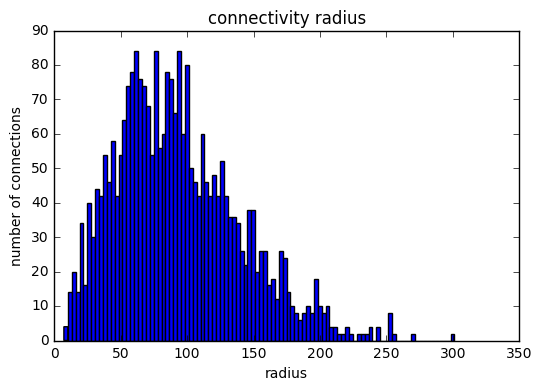

In [11]:
goc = read_in_coordfile(path_ivan+fns['go_coord'])
dis = get_distances(goc)

goal_range = [13.0, 14.0] #Goal range of number of average connections per cell    

kTi_gj, conn_gj = fit_Boltzmann (dis, goal_range)

res_gj, src_gj, tar_gj, dis_gj = conn_matrix_to_list(conn_gj)        

rad_prob_stats(kTi_gj)
conrad_hist(dis_gj) 
target_stats(np.array(tar_gj),'Golgi-to-Golgi gap junctions:')

#l_res_gj = [len(res_gj[l]) for l in range(len(res_gj))] #check for the number of connections per cell

### Synaptic connections

Golgi-to-Golgi synaptic connections
Connections per cell:  4.5 +/- 2.23 , range  1 - 11


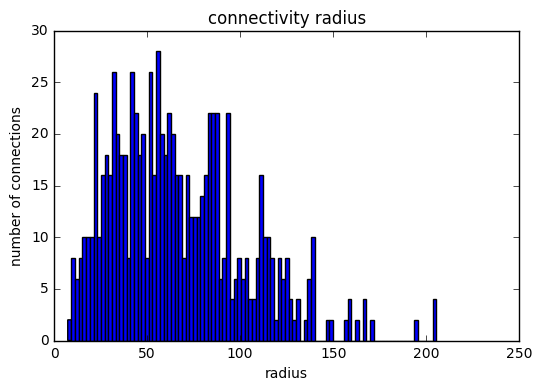

In [12]:
kTi_syn = -np.log(0.2)/50 # connection prob should be 20% at 50 ym, value from paper

conn_syn = get_Boltzmann_conn(dis, kTi_syn)
res_syn, src_syn, tar_syn, dis_syn = conn_matrix_to_list(conn_syn)

conrad_hist (dis_syn)    
target_stats(np.array(tar_syn),'Golgi-to-Golgi synaptic connections')

In [ ]:
#import networkx as nx
print (len(st_dis))

In [ ]:
print (np.array(list(res[0])))

## Example dataset#


### Read in the data, generate aa, pf, and dendritic tree

In [12]:
#Read in files
gr_ex = read_in_coordfile(path_dropin + 'GCcoordinates.dat')[:80000]
go_ex = read_in_coordfile(path_dropin + 'GoCcoordinates.dat')[:200]

#generate dendrites for Golgi cells
a_dend = dend_to_default_format(gen_dendrites(go_ex, a_r, a_h, a_m, a_std, a_sp))
b_dend = dend_to_default_format(gen_dendrites(go_ex, b_r, b_h, b_m, b_std, b_sp))
dends = np.concatenate((flatten_cells(a_dend), flatten_cells(b_dend)))
#and the corresponding Golgi cell indices
gol_ind = get_golgi_ind (a_dend, b_dend)

#generate aa and pf
aa_d = gen_aa_fixed (gr_ex, aa_length =230)
pf_d = gen_pf_from_aa (aa_d, pf_length)

#construct the 2d-trees
pf_tr = kdt(pf_d[:,0,1:])
aa_tr = kdt(aa_d[:,0,:2])

#critical radii
c_rad_pf = 5
c_rad_aa = 30


### Parallel fiber

In [13]:
go_gr_pf = [set() for i in range(len(go_ex))]
gr_go_pf = [set() for i in range(len(gr_ex))]

min_z = 230-c_rad_pf # minimal z coordinate to make inquiry reasonable (no parallel fibers possible underneath)
    
for i, pt in enumerate(dends):
    if pt[0] > min_z:
        warnings.simplefilter('ignore')
        ind, = pf_tr.query_radius(pt[1:], r= c_rad_pf)
        ind = ind[np.logical_and(pf_d[ind,0,0]<pt[0], pf_d[ind,1,0]>pt[0])]
        go_gr_pf[int(gol_ind[int(i)])].update(ind.astype('int'))
        for k in ind:
            gr_go_pf[int(k)].add(int(gol_ind[int(i)]))

### Ascending axon

In [16]:
gr_go_aa = [set() for i in range(len(gr_ex))]
go_gr_aa = [set() for i in range(len(go_ex))]

for i, pt in enumerate(dends):
    warnings.simplefilter('ignore')
    ind, = aa_tr.query_radius(pt[:2], r= c_rad_aa)
    ind = ind[np.logical_and(aa_d[ind,0,2]<pt[2], aa_d[ind,1,2]>pt[2])]
    go_gr_aa[int(gol_ind[i])].update(ind)
    for k in ind:
        gr_go_aa[int(k)].add(i)

### Visualization 1: 

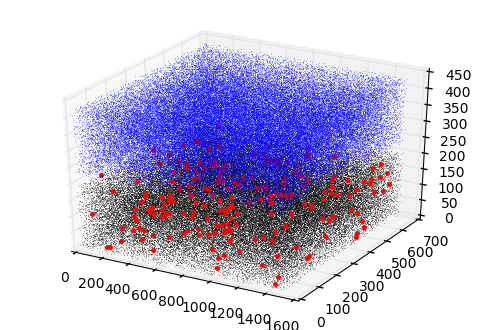

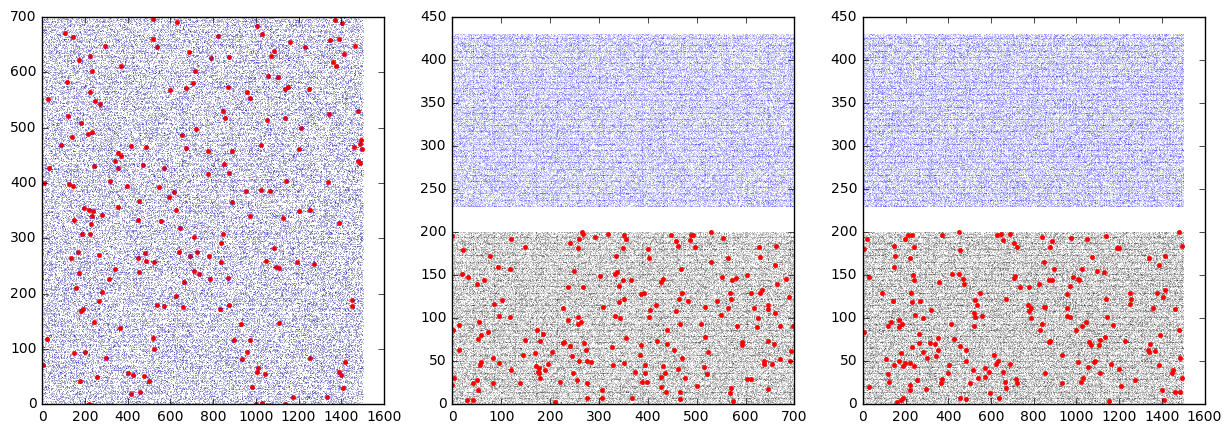

In [17]:
pop_1 =  gr_ex# small dots
pop_2 =  go_ex# big dots
pop_3 = aa_d[:,1,:] #blue dots

fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d(ax, pop_1, 'k.', markersize=0.2)
plot3d(ax, pop_2, 'r.')
plot3d(ax, pop_3, 'b.', markersize=0.2)

plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(pop_1[:,j], pop_1[:,k],  'k.', markersize=0.1)
    plt.plot(pop_2[:,j], pop_2[:,k],  'r.')
    plt.plot(pop_3[:,j], pop_3[:,k],  'b.', markersize=0.1)



90
2226


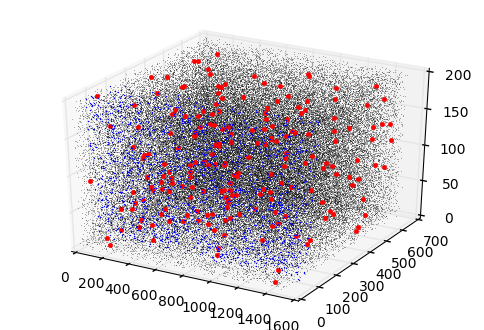

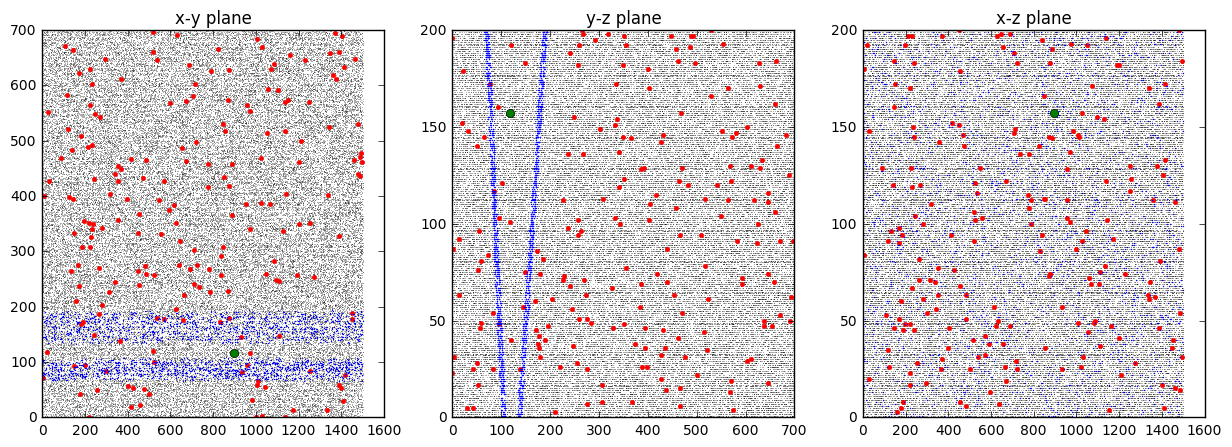

In [31]:
go_gr_pf_l = [len(go_gr_pf[i]) for i in range(len(go_gr_pf))]
n = np.argmax(go_gr_pf_l)
print (np.argmax(go_gr_pf_l))
print (max (go_gr_pf_l))

pop_1 =  gr_ex# small dots
pop_2 =  go_ex# big dots
pop_3 = gr_ex[(np.array(list(go_gr_pf[n]))).astype('int'), :] #blue dots


fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d(ax, pop_1, 'k.', markersize=0.2)
plot3d(ax, pop_2, 'r.')
plot3d(ax, pop_3, 'b.', markersize=1.0)

plt.figure(figsize=(15,5))
for i, [j, k, tit] in enumerate([[0,1, 'x-y plane'], [1,2, 'y-z plane'], [0,2, 'x-z plane']]):
    plt.subplot(1,3,i+1)
    plt.plot(pop_1[:,j], pop_1[:,k],  'k.', markersize=0.2)
    plt.plot(pop_2[:,j], pop_2[:,k],  'r.')
    plt.plot(pop_3[:,j], pop_3[:,k],  'b.', markersize=1.0)
    plt.plot(go_ex[n,j], go_ex[n,k], 'go')
    plt.title(tit)


## Kd-Trees

### General Background

- binary search stree
    - every branching node contains a k-dimensional point
    - every leaf node contains a set of points
- every branching node represents a splitting hyperplane that divides the space into two half-spaces    
    - left of the splitting hyperplane = left subtree, same for richt
    - each spliitting hyperplane is perpendicular to one of the axes in the k-dimensional space
    - the axes for the splitting hyperplanes are rotating

### On the chicken kd-tree library:
- works with datastructure POINT3D
    - constructor: make-point3d dbl dbl dbl 
    - accessors point3d-x /y/z
    - predicate: point3d?
- KD-Tree itself
    - constructor: list->kd-tree (list of POINT3D)
    - predicates: kd-tree? -> checks object, kd-tree-empty?, 
        - kd-tree-is-valid? -> checks if all points in subtree lie on left side of hyperplane and right on right
        - kd-tree-all-subtrees-are-valid? -> valid property for all branching nodes?
    - accessors: 
        - kd-tree->list  -> all the points contained in tree in a POINT3D list
        - kd-tree->list\* -> list with elements of the form (i . POINT3D) -> i is the relative integer index of the point
     
for other accessors, the author was not motivated enough to write a description.


### Pythonic Kd-Tree libraries:

#### Scipy:
- Documentation: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html
- Source Code: https://github.com/scipy/scipy/blob/master/scipy/spatial/kdtree.py
- Algorithm reference Maneewongvatana and Mount 1999
- Can be queried for r nearest neighbors, however r should be relatively small because elsewise, brute force is just as efficient.
- Approximate nearest neighbors seems to be another, and much faster option, and might work well for us.
- Uses pythonic libraries. 
- The heap queue algorithm: https://github.com/python/cpython/blob/2.7/Lib/heapq.py seems to be used, but it is also in python


#### SKlearn:
- Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html
- Source Code: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/kd_tree.pyx
- uses cython. Might thus be faster. Let's check.


Neither of them appears to have parallelization supported right from the beginning.
Both just take regular arrays as inputs.


Could be interesting:
http://ieeexplore.ieee.org/abstract/document/5654017/?reload=true
GPU implementation for kNN search
Following this:
https://link.springer.com/chapter/10.1007/978-3-642-38628-2_67



In [ ]:
from scipy.spatial import KDTree as T_sp
from sklearn.neighbors import KDTree as T_sk
s_dat = np.asarray(import_csv(fn_out))
import time

rn = np.random.randint(0, len(s_dat), 50)
nn = 10

In [ ]:
print (s_dat.shape)

In [ ]:
k_dist = np.zeros((len(rn), nn))
k_ind = np.zeros((len(rn), nn))
tk0 = time.time()
kt = T_sk(s_dat)
tk1 = time.time()
for i, ii in enumerate(rn):
    warnings.simplefilter('ignore') #definitely not ideal. But no clue how the validation file gets called
    k_dist[i,:], k_ind [i,:] = kt.query(s_dat[ii,:], k = nn)
tk2 = time.time()

In [ ]:
p_dist = np.zeros((len(rn), nn))
p_ind = np.zeros((len(rn), nn))
tp0 = time.time()
pt = T_sp(s_dat)
tp1 = time.time()
for i, ii in enumerate(rn):
    p_dist[i,:], p_ind [i,:] = pt.query(s_dat[ii,:], k = nn)
tp2 = time.time()

In [ ]:
#Here is the first, blunt comparison of both algorithms in terms of time:
print (tk1-tk0)
print (tp1-tp0)

print (tk2-tk1)
print (tp2-tp1)
#Scikit-learn is way faster.

#print (np.isclose (k_dist, p_dist))
#print (k_ind -p_ind) 
# Where the indices are not the same it is because the distances are equal.

In [ ]:
# Reading in, subsampling and storing again the csv files in order to have a smaller dataset at hand that has a similar density anyway.

import csv

fn_in = 'input_files/GCTcoordinates.dat'
fn_out = 'input_files/GCT_small.dat' #100x150 -> 11 k
fn_out2 = 'input_files/GCT_smallsmall.dat' #30x100 -> 2.2k
fn_out3 = 'input_files/GCT_tiny.dat' # 2x5 ->  6

x_r = [0.0, 2.0]
y_r = [0.0, 5.0]
z_r = [0.0, 1000.0]
rrs = [x_r, y_r, z_r]

def subsample_coords (rrs, fn_in, fn_out = 'input_files/downsampled.dat', save = True):
    res = []
    rnr = [0, 0]
    with open(fn_in, newline = '') as f, open (fn_out, 'w', newline = '') as w_f:
        rr = csv.reader(f, delimiter = ' ')
        if save: wr = csv.writer(w_f, delimiter = ' ')
        for line in rr:
            in_range = all([float(line[i])>rrs[i][0] and float(line[i])<rrs[i][1] for i in range(len(rrs))]) #check if in range
            if in_range: 
                if save: wr.writerow([float(line[j]) for j in range(len(rrs))])
                res.append([float(line[j]) for j in range(len(rrs))])
                rnr[0] = rnr[0]+1
            else:
                rnr[1] = rnr[1]+1
    print ('Subsampled {} of {}'.format(rnr[0], rnr[1]))
    return res

#my_s = subsample_coords (rrs, fn_in, fn_out3, save = True)

def import_csv (fn):
    res = []
    with open (fn, newline = '') as f:
        rr = csv.reader(f, delimiter = ' ')
        for line in rr:
            res.append([float(line[j]) for j in range(len(line))])
    return np.asarray(res)


## Random and deprecated stuff below this.

In [ ]:
# Development site for the read_in_config function.

#from neuron import hoc, h
# weird thing that I did not get yet: despite all the copy statements, the second time you calculate d_l, it would give 0. 
# Thus, the hoc objects must somehow take on each other's parameters... 

#load an empty hoc object and find out which parameters are native to that object (probably useless...)
empty_hoc = dir(neuron.hoc.HocObject()).copy()
config_fn = './input_files/Parameters.hoc'
overwrite_config =  True
#load our own hoc object from the parameter file, get the disjunct list of parameters (probably useless...)
neuron.h.xopen(config_fn)
full_hoc = dir(neuron.h)
if 'd_l' not in globals():
    d_l = list (set (full_hoc)  - set (empty_hoc)).copy()

#c_d = b.config_dict
c_d = dict((v,k) for k,v in b.config_dict.items()) #exchange key and value
#this dict translates the parameters used in the Parameters file to the ones used in the code
# Check if the Brep object contains the right parameters and if so, change them.
# Note: Resolve conflicts with the command line - I think default should be that command line should has priority 
self = b
for h_k in full_hoc:
    if h_k in c_d.keys() and h_k not in self.cl_args.keys():
        if hasattr (self.args, c_d[h_k]):
            setattr (self.args, c_d[h_k], getattr (neuron.h, h_k))
        else:
            print ('Did not find {}'.format(c_d[h_k]))
    elif h_k in c_d.keys() and h_k in self.cl_args.keys():
        if hasattr (self.args, c_d[h_k]):
            if overwrite_config:
                warnings.warn('Parameter {} was set both by command line and in config, will use value from command line'.format(c_d[h_k]))
            else:
                warnings.warn('Parameter {} was set both by command line and in config, will use value from config file'.format(c_d[h_k]))
                setattr (self.args, c_d[h_k], getattr (neuron.h, h_k))
    
# The following two parameters are an exception:
if 'GLdepth' in d_l and 'PCLdepth' in d_l and not 'aa-length' in self.cl_args.keys():
    setattr (self.args, 'aa-length', getattr(neuron.h, 'GLdepth')+getattr(neuron.h,'PCLdepth'))
    


In [ ]:
### The transformations of the parameters, automized in a small parser script.

#Had to be done only once, but will be kept for reference.

from neuron import hoc, h
# weird thing that I did not get yet: despite all the copy statements, the second time you calculate d_l, it would give 0. 
# Thus, the hoc objects must somehow take on each other's parameters... 

#load an empty hoc object and find out which parameters are native to that object (probably useless...)
empty_hoc = dir(hoc.HocObject()).copy()
config_fn = './input_files/Parameters.hoc'
#load our own hoc object from the parameter file, get the disjunct list of parameters (probably useless...)
h.xopen(config_fn)
full_hoc = dir(h).copy()
if 'd_l' not in globals():
    d_l = list (set (full_hoc)  - set (empty_hoc)).copy()

# Code file
tf = 'brep_commented.scm'
# Step one: parse all lines that contain both config or options as those are the ones that 
res_dict = {}
with open (tf, 'rb') as tff:
    for line in tff:
        st = str(line)
        c = st.find ("config '")
        o = st.find ("options '") 
        if c > 0 and o > 0:
            c_clb = st[c:].find (')')
            o_clb = st[o:].find (')')
            res_dict[st[c+8:c+c_clb]] = st[o+9:o+o_clb] 
    tff.close()

#parameters that are defined in the res file but have not been parsed yet
rest_hk = (set (d_l)- set(res_dict.keys()))
rem = {}
#check if they occur in the code
with open ('brep_commented.scm', 'rb') as f_in:
    n = 0
    for line in f_in:
        n = n+1
        for w in rest_hk:
            if str(line).find(w)>0:
                if w in rem.keys():
                    rem[w].append(n)
                else:
                    rem[w] = [n]                  
print (rem) # 'TS is coincidental, the other two parameters are taken seperate care of.

#print the resulting dict to a file.
with open ('par_d2.txt', 'w') as f_out:
    for k in res_dict.keys():
        f_out.write("'" +res_dict[k]+ "' : '"+k+ "', \n" )

#print (res_dict)

In [ ]:
#Used this to try out command line calls. 

#Brep = importlib.reload(BREPpy)
#stupid workaround so that the known command line call can be kept up.
#I think I changed something, would have to git checkout....
class Brep2 (Brep, b):
    def __init__:
        self.args = b.args
        self.config_dict = b.config_dict
        self.cl_args = b.cl_args
        


def new_Brep (arg_dict = {}, **kwargs):
    if True: #delete and make new Brep file
        ! python ~/Desktop/LabRot_OIST/pybrep/BREPpy.py --config_file blabla 
        a = pkl.load(open('./tmp.pkl', 'rb'))
        ! rm tmp.pkl
        b = Brep2(a)
    else: b = Brep2(pkl.load(open('./tmp.pkl', 'rb'))) 
    #Process and add arguments    
    arg_dict.update(kwargs)
    for k in arg_dict.keys():
        if hasattr (b.args, k):
            setattr (b.args, k, arg_dict[k])
        else:
            warnings.warn ('Keyline argument {} not known'.format(k))
            
    return b

arg_dict = {'config_file': 'blabla.c',
            'verbose': True}
b = new_Brep(arg_dict, gc_points_fn = 'yipyip' )


In [ ]:
## Fun with magic

# http://ipython.readthedocs.io/en/stable/interactive/magics.html
#notable ones
# %debug #-> debug stuff. Lets you inspect the stack frame of an exception interactively
# %env #-> see all env variables

In [ ]:
### Used this to develop the soma rendering algorithm

dat = Gr_co

print (dat.shape)

lower = dat.T.ravel()
upper = -(dat-[Gc_x, Gc_y, Gc_z]).T.ravel()
most_out_idx = np.mod(np.argsort(np.concatenate((lower,upper))), len(dat))

n_del = 500
dat = dat[np.setdiff1d(np.arange(len(dat)), most_out_idx[:n_del]),:]

print (dat.shape)

test_ar = np.array([[0,1,3],[-1,3,5],[2,3,4], [5,3,2]])
print (test_ar.ravel())
print (np.argsort(test_ar.T.ravel()))
tt2 = test_ar- [1,2,3]
print (tt2)

print ('')
most_out = np.argsort(np.concatenate(( test_ar.T.ravel(), -(test_ar-[1,2,3]).T.ravel() )))

most_out_idx = np.mod(most_out, len(test_ar))

print (len(test_ar))
print( -(test_ar-[1,2,3]))
print( -(test_ar-[1,2,3]).ravel())
print (np.argsort( -(test_ar-[1,2,3]).ravel()))

print ('')
print (np.concatenate(( test_ar.ravel(), -(test_ar-[1,2,3]).ravel() )))
print (most_out)
print (most_out_idx)
print 

print ('')
print (test_ar)
print( -(test_ar-[1,2,3]))
#hs = np.sum(np.heaviside(-dat) + np.heaviside(dat-[Gc_x, Gx_y, Gc_z]))

In [ ]:
(332**2 + 100**2)**0.5 / 24

In [ ]:
(6**2+60**2)**0.5/12